In [1]:
# Scrierea și comentarea codului.           Done
# Implimentarea clasei Vocabular.
# Implimentarea clasei Data set.            Done
# Implimentarea rețelei neuronale.          Done
# Implimentarea ciclului de învănțare.      Done 
# Prezentța graficului cu Learning Curve pentru acuratețe și eroare.  Done
# Reantrenarea modelului cu cem mai bun rezultat după learning curve. Done

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim 
from torchvision import transforms
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from torch import nn as nn
from collections import Counter
import itertools
import gensim
import os
import spacy

In [3]:
#Implementing Dataset class
class Data(Dataset):
    def __init__(self, data, device):
        self.data = data
        self.token_index = torch.transpose(torch.tensor(list(itertools.zip_longest(*data['index_tokens'], fillvalue=PAD_token))), dim0 = 0 , dim1 = 1).to(device)
        self.sentiments_encoded = nn.functional.one_hot(torch.tensor(data['sentiment']),num_classes=3).to(device)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.token_index[index],self.sentiments_encoded[index]

In [4]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# Vocabulary class
class Vocabulary:
    def __init__(self, path_to_train, path_to_test, name, stemmer, device):
        self.train = pd.read_csv(path_to_train, usecols = [2,3], names=['sentiment', 'content'])
        self.test = pd.read_csv(path_to_test, usecols = [2,3], names=['sentiment', 'content'])
        self.stemmer = stemmer
        self.trained = False
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD
        self.device = device
        self.stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
        #loading the english language small model of spacy

    def addSentence(self):
        
        self.train['tokens'] = self.train['content'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word)>2 and word not in self.stopwords]))
        self.test['tokens'] = self.test['content'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word)>2 and word not in self.stopwords]))
        for sentence in self.train['content']:
            for word in word_tokenize(str(sentence)):
                if len(word)>2 and word not in self.stopwords:
                    self.addWord(word.lower())
        self.train['index_tokens'] =  self.train['tokens'].apply(lambda x : np.array([self.word2index[word] for word in x] + [EOS_token]))
        self.test['index_tokens'] =  self.test['tokens'].apply(lambda x : np.array([self.word2index[word] for word in x if word in self.word2index] + [EOS_token]))
          

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
     
    
    def indexesFromSentence(self, sentence):
        return [self.word2index[word] for word in sentence] + [EOS_token]
    
    def word2vec(self,):
        model_train = gensim.models.Word2Vec(self.train['tokens'].sum(), min_count = 1, 
                              size = 100, window = 5)
        
        model_test = gensim.models.Word2Vec(self.test['tokens'].sum(), min_count = 1, 
                              size = 100, window = 5)

In [5]:
# Network class
class GRU(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, num_words, drop_prob=0.2):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(num_words, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.soft = torch.nn.Softmax()
        
    def forward(self, x, h = None):
        x = self.embedding(x)
        if h is None:
            h = self.init_hidden(256)
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.soft(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [6]:
# Train loop 
def train(epochs, optimizer, model, loss_fn, train_loader, test_loader, device, l2=0.001, print_plot=True):
    
    train_accuracy = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)
    
    train_loss = np.zeros(epochs)
    test_loss = np. zeros(epochs)
    for epoch in range(epochs):
        # Train
        model.train()
        total = 0
        correct = 0
        current_train_loss = 0.0

        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(device)
            labels = labels.to(device).float()

            # running our data thru our data - forward
            predicted, _ = model(example)
            # Getting loss of our network right now
            loss = loss_fn(predicted, labels)
            current_train_loss += loss    # Check if should not detatch?

            total += labels.shape[0]
            predicted = torch.round(predicted)
            correct += int((predicted == labels).all(axis=1).sum())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
        train_accuracy[epoch] = correct / total
        train_loss[epoch] = current_train_loss / total
        # Test
        model.eval()
        correct = 0
        total = 0
        current_test_loss = 0
        for example, labels in test_loader:

            #Translating calculations to gpu if is available
            example = example.to(device)
            labels = labels.to(device).float()
            
            #Forward
            predicted, _ = model(example)
            #Loss
            loss = loss_fn(predicted, labels)
            current_test_loss += loss # Check for detatch
            
            total += labels.shape[0]
            predicted = torch.round(predicted)

            correct += int((predicted  == labels).all(axis=1).sum())
            
        test_accuracy[epoch] = correct / total
        test_loss[epoch] = current_test_loss / total
        
        #Print results for epochs
        #if epoch % 10 == 0:
        print('Epoch {0}, Training loss - {1}, Test loss {2}'.format(epoch,current_train_loss, current_test_loss))


    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs_range = range(1,epochs+1)
        
       # fig, ax = plt.subplots(nrows=1, ncols=2)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_loss, 'g', label='Training loss')
        plt.plot(epochs_range, test_loss, 'b', label='Test loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # #Ploting both curves, train and val 
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs_range, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [15]:
# Loading data
path_to_data = 'GRU/data'
path_to_train = os.path.join(path_to_data, 'twitter_training.csv')
path_to_test = os.path.join(path_to_data, 'twitter_validation.csv')

device = torch.device('cuda')
# Applying the vocabulary

ps = PorterStemmer()

vocabulary = Vocabulary(path_to_train, path_to_test, name = 'name', stemmer = ps, device = device)
vocabulary.addSentence()

In [16]:
train_set = vocabulary.train[['index_tokens', 'sentiment']]
test_set = vocabulary.test[['index_tokens', 'sentiment']]

In [17]:
train_set['sentiment'] = train_set['sentiment'].replace({'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2})
test_set['sentiment'] = test_set['sentiment'].replace({'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2})

C:\Users\vladi\AppData\Local\Temp/ipykernel_15388/2674311417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['sentiment'] = train_set['sentiment'].replace({'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2})
C:\Users\vladi\AppData\Local\Temp/ipykernel_15388/2674311417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['sentiment'] = test_set['sentiment'].replace({'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 2})


In [18]:
train_dataset = Data(train_set, device = device)
test_dataset = Data(test_set, device = device)

In [19]:
train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True,  drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=256, shuffle=True, drop_last=True
)

In [20]:
# Testing model

learning_rate = 1e-3
hidden_dim = 200
#Initializing model with nr of features from input
model = GRU(num_words = vocabulary.num_words, hidden_dim = hidden_dim, output_dim = 3, n_layers = 2).to(device)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()  

C:\Users\vladi\AppData\Local\Temp/ipykernel_15388/2283120159.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.soft(out)


Epoch 0, Training loss - 300.0850830078125, Test loss 2.6242570877075195
Epoch 1, Training loss - 248.80735778808594, Test loss 2.2738051414489746
Epoch 2, Training loss - 227.63717651367188, Test loss 2.127178907394409
Epoch 3, Training loss - 215.5935821533203, Test loss 2.0602972507476807
Epoch 4, Training loss - 208.55728149414062, Test loss 1.9993711709976196
Epoch 5, Training loss - 203.0902557373047, Test loss 1.9715352058410645
Epoch 6, Training loss - 200.43052673339844, Test loss 1.9422270059585571
Epoch 7, Training loss - 197.1678009033203, Test loss 1.9551365375518799
Epoch 8, Training loss - 195.1479034423828, Test loss 1.9523696899414062
Epoch 9, Training loss - 194.10745239257812, Test loss 1.9712342023849487


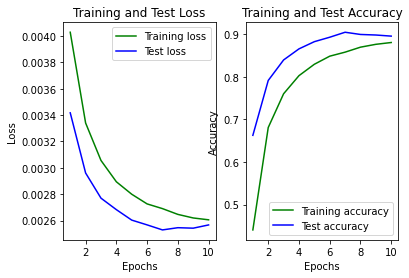

In [21]:
#Running training loop on the data with set parameters
train(
    epochs=10,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

C:\Users\vladi\AppData\Local\Temp/ipykernel_15388/2283120159.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.soft(out)


Epoch 0, Training loss - 299.7362365722656, Test loss 2.5926637649536133
Epoch 1, Training loss - 247.67526245117188, Test loss 2.2446165084838867
Epoch 2, Training loss - 225.0295867919922, Test loss 2.099224328994751
Epoch 3, Training loss - 213.80247497558594, Test loss 2.0525355339050293
Epoch 4, Training loss - 207.67144775390625, Test loss 2.0047671794891357
Epoch 5, Training loss - 203.31866455078125, Test loss 1.9747873544692993
Epoch 6, Training loss - 199.52833557128906, Test loss 1.9469735622406006


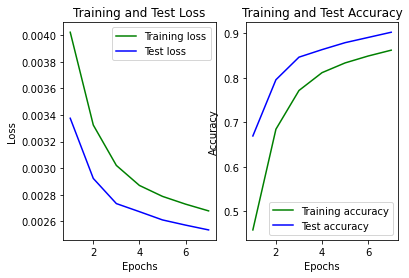

In [24]:
#model retrain
learning_rate = 1e-3
hidden_dim = 200
#Initializing model with nr of features from input
model = GRU(num_words = vocabulary.num_words, hidden_dim = hidden_dim, output_dim = 3, n_layers = 2).to(device)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()   

#Running training loop on the data with set parameters
train(
    epochs=7,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)